In [12]:
%pip install -U --quiet langgraph langsmith langchain_openai

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("LANGCHAIN_API_KEY")
_getpass("OPENAI_API_KEY")

In [ ]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

In [ ]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

In [ ]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    res = await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

In [ ]:
import asyncio
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [ ]:
llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [ ]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [ ]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

#### Run Agent

In [13]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['6', 'LangGraph tutorial conversation generation pipeline FWD sales agent']
2. Click: ['19']
3. Click: ['0']
4. Click: ['41']
5. Click: ['33']
6. Click: ['33']
7. Click: ['33']
8. Click: ['16']
9. Google: None
10. Type: ['6', 'LangGraph tutorial conversation generation pipeline FWD sales agent']
11. Click: ['21']
12. Click: ['5']
13. GoBack: None
14. Click: ['21']
15. Scroll: ['WINDOW', 'down']
16. Click: ['25']
17. Click: ['20']
18. Click: ['15']
19. Click: ['20']
20. Click: ['20']
21. Click: ['15']
22. Click: ['19']
23. Click: ['15']
24. Click: ['19']
25. Click: ['0']


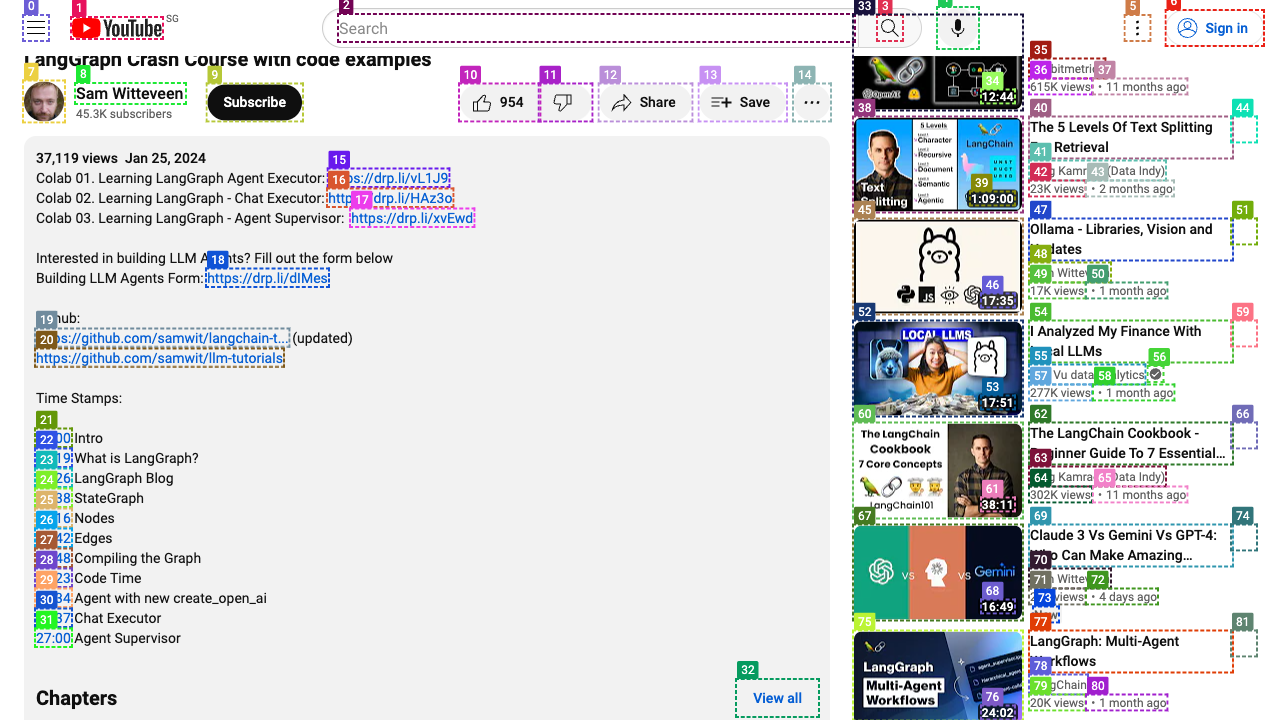

GraphRecursionError: Recursion limit of 150 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [14]:
res = await call_agent("Go search for LangGraph's turorial and tell me how I should write a basic conversation generation pipeline, where a FWD sales agent chat with a customer", page)
print(f"Final response: {res}")

1. Google: None
2. Type: ['6', 'Langchain blog']
3. Click: ['25']
4. ANSWER;: ['The latest blog posts from LangChain include "[Week of 3/4] LangChain Release Notes", "OpenGPTs", and "LangGraph: Multi-Agent Workflows".']


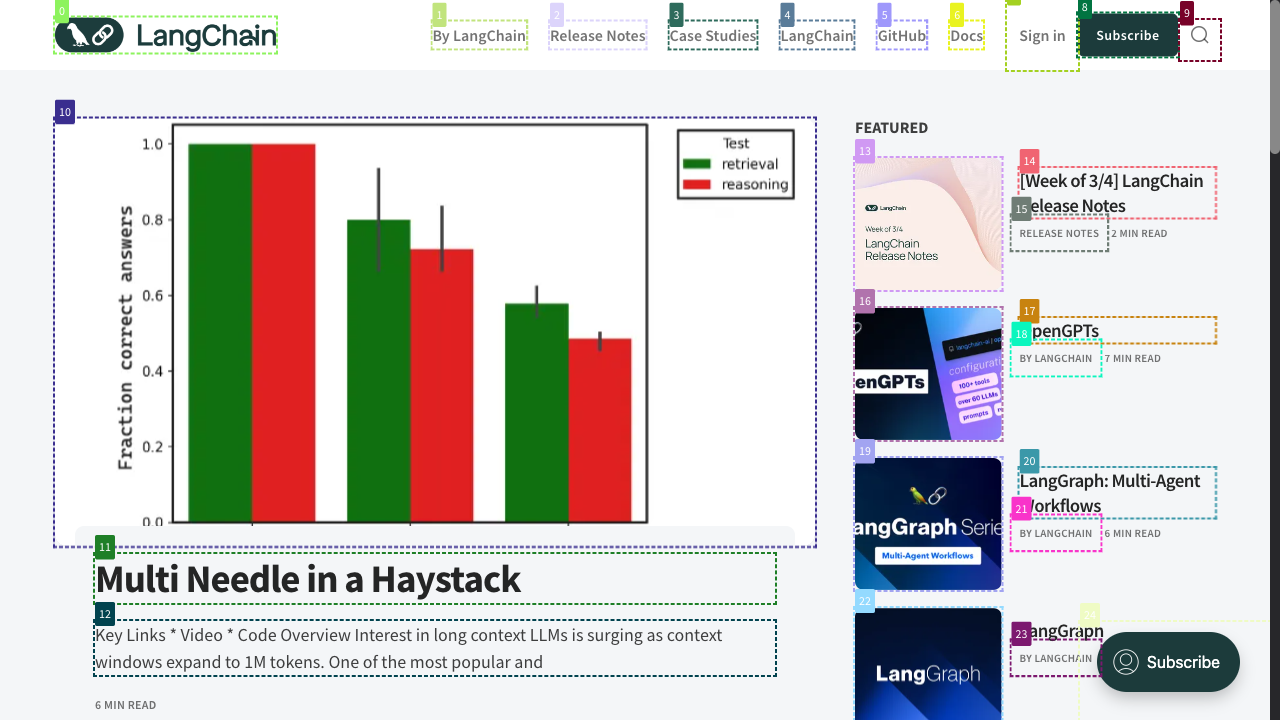

Final response: The latest blog posts from LangChain include "[Week of 3/4] LangChain Release Notes", "OpenGPTs", and "LangGraph: Multi-Agent Workflows".


In [ ]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

1. Click: ['0']
2. Google: None
3. Type: ['6', 'SF downtown to SFO by 7am']
4. Click: ['10']
5. Click: ['7']
6. Click: ['9']
7. Click: ['19']
8. Click: ['0']
9. Type: ['7', 'SF downtown']
10. Click: ['19']
11. Click: ['22']
12. Click: ['35']
13. Scroll: ['WINDOW', 'up']
14. Scroll: ['WINDOW', 'up']
15. Scroll: ['WINDOW', 'up']
16. Click: ['10']
17. Click: ['3']
18. Type: ['0', 'SF downtown to SFO by 7am']
19. Click: ['0']
20. Click: ['10']
21. Click: ['22']
22. Click: ['2']
23. Click: ['16']
24. Click: ['9']
25. Click: ['22']


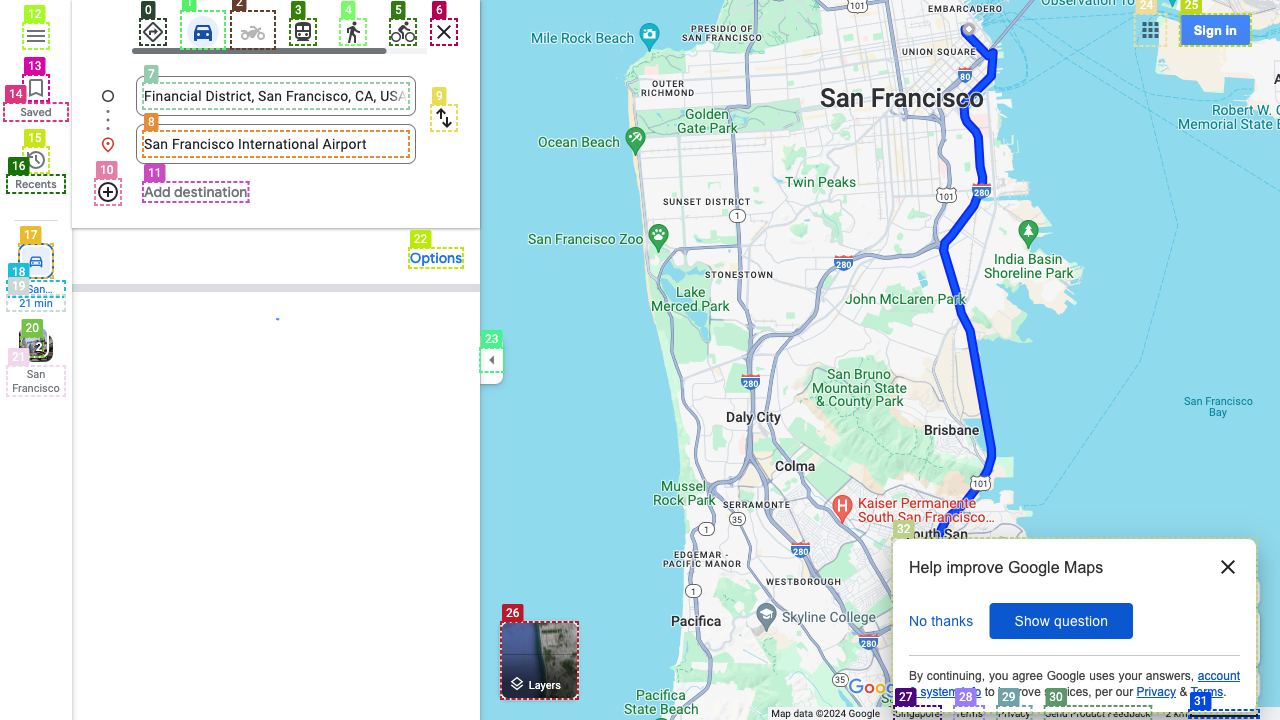

GraphRecursionError: Recursion limit of 150 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [ ]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")